In [1]:
import numpy as np

from seqeval.metrics import f1_score
from transformers import EvalPrediction

from transformers import TrainingArguments
from datasets import get_dataset_config_names
from datasets import load_dataset

from transformers import DataCollatorForTokenClassification

from collections import defaultdict
from datasets import DatasetDict

from collections import Counter

from transformers import Trainer

import torch.nn as nn
from matplotlib import pyplot as plt
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

import torch

from transformers import AutoConfig
from transformers import AutoTokenizer

from seqeval.metrics import classification_report

In [2]:
xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [3]:
xtreme_subsets

['XNLI',
 'tydiqa',
 'SQuAD',
 'PAN-X.af',
 'PAN-X.ar',
 'PAN-X.bg',
 'PAN-X.bn',
 'PAN-X.de',
 'PAN-X.el',
 'PAN-X.en',
 'PAN-X.es',
 'PAN-X.et',
 'PAN-X.eu',
 'PAN-X.fa',
 'PAN-X.fi',
 'PAN-X.fr',
 'PAN-X.he',
 'PAN-X.hi',
 'PAN-X.hu',
 'PAN-X.id',
 'PAN-X.it',
 'PAN-X.ja',
 'PAN-X.jv',
 'PAN-X.ka',
 'PAN-X.kk',
 'PAN-X.ko',
 'PAN-X.ml',
 'PAN-X.mr',
 'PAN-X.ms',
 'PAN-X.my',
 'PAN-X.nl',
 'PAN-X.pt',
 'PAN-X.ru',
 'PAN-X.sw',
 'PAN-X.ta',
 'PAN-X.te',
 'PAN-X.th',
 'PAN-X.tl',
 'PAN-X.tr',
 'PAN-X.ur',
 'PAN-X.vi',
 'PAN-X.yo',
 'PAN-X.zh',
 'MLQA.ar.ar',
 'MLQA.ar.de',
 'MLQA.ar.vi',
 'MLQA.ar.zh',
 'MLQA.ar.en',
 'MLQA.ar.es',
 'MLQA.ar.hi',
 'MLQA.de.ar',
 'MLQA.de.de',
 'MLQA.de.vi',
 'MLQA.de.zh',
 'MLQA.de.en',
 'MLQA.de.es',
 'MLQA.de.hi',
 'MLQA.vi.ar',
 'MLQA.vi.de',
 'MLQA.vi.vi',
 'MLQA.vi.zh',
 'MLQA.vi.en',
 'MLQA.vi.es',
 'MLQA.vi.hi',
 'MLQA.zh.ar',
 'MLQA.zh.de',
 'MLQA.zh.vi',
 'MLQA.zh.zh',
 'MLQA.zh.en',
 'MLQA.zh.es',
 'MLQA.zh.hi',
 'MLQA.en.ar',
 'MLQA.en.de',


In [4]:
panx_subset = [s for s in xtreme_subsets if s.startswith('PAN')]
panx_subset

['PAN-X.af',
 'PAN-X.ar',
 'PAN-X.bg',
 'PAN-X.bn',
 'PAN-X.de',
 'PAN-X.el',
 'PAN-X.en',
 'PAN-X.es',
 'PAN-X.et',
 'PAN-X.eu',
 'PAN-X.fa',
 'PAN-X.fi',
 'PAN-X.fr',
 'PAN-X.he',
 'PAN-X.hi',
 'PAN-X.hu',
 'PAN-X.id',
 'PAN-X.it',
 'PAN-X.ja',
 'PAN-X.jv',
 'PAN-X.ka',
 'PAN-X.kk',
 'PAN-X.ko',
 'PAN-X.ml',
 'PAN-X.mr',
 'PAN-X.ms',
 'PAN-X.my',
 'PAN-X.nl',
 'PAN-X.pt',
 'PAN-X.ru',
 'PAN-X.sw',
 'PAN-X.ta',
 'PAN-X.te',
 'PAN-X.th',
 'PAN-X.tl',
 'PAN-X.tr',
 'PAN-X.ur',
 'PAN-X.vi',
 'PAN-X.yo',
 'PAN-X.zh']

In [5]:
dataset = load_dataset('xtreme',name='PAN-X.de')

Found cached dataset xtreme (/home/raj/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [7]:
languages = ['de','fr','it','en']
#de : Germen, fr: france, it:Italian, en: English
prercentage_lang_spoken = [0.629,0.229,0.084,0.059]

panx_ds_combined = defaultdict(DatasetDict)

In [8]:
panx_ds_combined

defaultdict(datasets.dataset_dict.DatasetDict, {})

In [9]:
for lang,percentage in zip(languages,prercentage_lang_spoken):
    ds = load_dataset('xtreme',name=f'PAN-X.{lang}')
    for train_test_val in ds:
        panx_ds_combined[lang][train_test_val] = (
            ds[train_test_val].shuffle(seed=0).select(range(int(percentage*ds[train_test_val].num_rows)))
        )

Found cached dataset xtreme (/home/raj/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-e5ddf09f1ae095ec.arrow
Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-25e7e2dd003d0fa6.arrow
Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-73a95bc0accfea8b.arrow
Found cached dataset xtreme (/home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-6ff29513007ec78b.arrow
Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-c5c9a4fc19dfd7d6.arrow
Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-9711ab25936b81b7.arrow
Found cached dataset xtreme (/home/raj/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-daa9a1770078307c.arrow
Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-5e244c05031bab3c.arrow
Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-497ee15c12bff58d.arrow
Found cached dataset xtreme (/home/raj/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-757845faa9fa6949.arrow
Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-305cefc7ffa49fd9.arrow
Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-e5ec5e6ba7c1237d.arrow


In [10]:
panx_ds_combined

defaultdict(datasets.dataset_dict.DatasetDict,
            {'de': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 12580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
             }),
             'fr': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 4580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 2290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'la

In [11]:
import pandas as pd

pd.DataFrame({lang: [ panx_ds_combined[lang]['train'].num_rows] for lang in languages })

,de,fr,it,en
0,12580,4580,1680,1180


In [12]:
element = panx_ds_combined['de']['train'][0]
print(panx_ds_combined['de']['train'].features)
for key,value in element.items():
    print(f"{key}:{value}")

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None), 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}
tokens:['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags:[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs:['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [13]:
tags = panx_ds_combined['de']['train'].features['ner_tags'].feature
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [14]:
def create_tag_names(batch):
    return {'ner_tags_str' : [tags.int2str(idx) for idx in batch['ner_tags']]}

panx_de = panx_ds_combined['de'].map(create_tag_names)
panx_de

Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-365871c98eb5223e.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-f321c19e5dd9c232.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-4453e3cf0a67f823.arrow


DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})

In [15]:
panx_de['train'][0]['ner_tags_str']

['O',
 'O',
 'O',
 'O',
 'B-LOC',
 'I-LOC',
 'O',
 'O',
 'B-LOC',
 'B-LOC',
 'I-LOC',
 'O']

In [16]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [17]:
from collections import Counter

def get_ner_frequencies(panx_de):
  split2freqs = defaultdict(Counter)
  for split, dataset in panx_de.items():
      for row in dataset["ner_tags_str"]:
          for tag in row:
              if tag.startswith("B"):
                  tag_type = tag.split("-")[1]
                  split2freqs[split][tag_type] += 1
  return split2freqs

freqs = get_ner_frequencies(panx_de)

pd.DataFrame.from_dict(freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


Creating a Custom model for Token Classification

In [18]:
import torch.nn as nn
from matplotlib import pyplot as plt
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig
    def __init__(self,config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config,add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size,config.num_labels)
        self.init_weights()

    def forward(self,input_ids=None,attention_mask=None,token_type_ids=None, 
        labels=None, **kwargs):
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                        token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                hidden_states=outputs.hidden_states, 
                                attentions=outputs.attentions)


In [19]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [20]:
index2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC'}

In [21]:
tag2index

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6}

In [22]:
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [23]:
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [24]:
xlmr_config

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

xlmr_my_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['roberta.embeddings.position_ids', 'classifier.bias', '

In [26]:
example_string = 'World will be changed with AI'

xlmr_token = xlmr_tokenizer(example_string).tokens()
xlmr_token

['<s>', '▁World', '▁will', '▁be', '▁changed', '▁with', '▁AI', '</s>']

In [27]:
bert_tokens = bert_tokenizer(example_string).tokens()
bert_tokens

['[CLS]', 'World', 'will', 'be', 'changed', 'with', 'AI', '[SEP]']

In [28]:
def tag_text(text, tags, model, tokenizer):
    """
    Function to tag text using a pretrained model and tokenizer.

    Parameters:
    text (str): Text to be tagged.
    tags (Tags): An instance of the Tags class that maps class indices to names.
    model (Model): Pretrained model for named entity recognition.
    tokenizer (Tokenizer): Pretrained tokenizer corresponding to the model.

    Returns:
    pd.DataFrame: DataFrame containing the original tokens and their corresponding tags.
    """
    # Tokenize the text, preserving special characters
    tokens = tokenizer(text).tokens()

    # Encode the tokens into their corresponding IDs
    # 'return_tensors="pt"' indicates that we want PyTorch tensors
    # '.to(device)' sends the tensors to the GPU if one is available
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)

    # Print the input IDs for debugging purposes
    print('input_ids ', input_ids)

    # Get the model's predictions as a distribution over possible classes
    # Each token is associated with a probability distribution over the 7 possible NER tags
    outputs = model(input_ids)[0]
    print(f"Shape of outputs: {outputs.shape}")

    # Take the argmax over the tag dimension to get the most likely class for each token
    predictions = torch.argmax(outputs, dim=2)
    print('predictions ', predictions)

    # Convert the predictions from class indices to class names using the 'tags' object
    # '.cpu().numpy()' moves the tensor from GPU to CPU and converts it to a NumPy array
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]

    # Return the tokens and their corresponding tags as a DataFrame
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [29]:
print(tags)
print(xlmr_tokenizer)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)
XLMRobertaTokenizerFast(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True)


In [30]:
tag_text(example_string, tags, xlmr_my_model, xlmr_tokenizer)

input_ids  tensor([[    0,  6661,  1221,   186, 98816,   678, 38730,     2]],
       device='cuda:0')
Shape of outputs: torch.Size([1, 8, 7])
predictions  tensor([[5, 5, 5, 5, 5, 5, 5, 5]], device='cuda:0')


,0,1,2,3,4,5,6,7
Tokens,<s>,▁World,▁will,▁be,▁changed,▁with,▁AI,</s>
Tags,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC


In [31]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [32]:
words,labels

(['2.000',
  'Einwohnern',
  'an',
  'der',
  'Danziger',
  'Bucht',
  'in',
  'der',
  'polnischen',
  'Woiwodschaft',
  'Pommern',
  '.'],
 [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0])

In [33]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)

tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['<s>',
 '▁2.000',
 '▁Einwohner',
 'n',
 '▁an',
 '▁der',
 '▁Dan',
 'zi',
 'ger',
 '▁Buch',
 't',
 '▁in',
 '▁der',
 '▁polni',
 'schen',
 '▁Wo',
 'i',
 'wod',
 'schaft',
 '▁Po',
 'mmer',
 'n',
 '▁',
 '.',
 '</s>']

In [34]:
word_ids = tokenized_input.word_ids()
print('word_ids ', word_ids)

pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

word_ids  [None, 0, 1, 1, 2, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, None]


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [35]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    # And then update previous_word_idx
    # to be current word
    previous_word_idx = word_idx

print('label_ids ', label_ids)
    
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

label_ids  [-100, 0, 0, -100, 0, 0, 5, -100, -100, 6, -100, 0, 0, 5, -100, 5, -100, -100, -100, 6, -100, -100, 0, -100, -100]


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [36]:
def tokenize_mask_modify_labels(examples):
    """
    Function to tokenize the input text, mask certain tokens, and adjust the labels accordingly.

    Parameters:
    examples (dict): A dictionary containing the input text and labels. The input text ("tokens") is a list of words, 
                     and the labels ("ner_tags") are a corresponding list of NER tags.

    Returns:
    tokenized_inputs (dict): A dictionary containing the tokenized input text and modified labels. The tokenized input 
                             text is a list of token IDs, and the modified labels are a corresponding list of NER tags, 
                             with -100 indicating masked tokens.
    """
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        # word_ids() => Return a list mapping the tokens
        # to their actual word in the initial sentence.
        # It Returns a list indicating the word corresponding to each token. 
        previous_word_idx = None
        label_ids = []
        # Special tokens like `<s>` and `<\s>` are mapped to None. 
        # Set –100 as the label for these special tokens and
        # the subwords we wish to mask during training:
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [37]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_mask_modify_labels, batched=True, 
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [38]:
panx_de_encoded = encode_panx_dataset(panx_ds_combined["de"])

Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-ee43ed1891039798.arrow


Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-3b09521252c88e6d.arrow


In [39]:
panx_de_encoded["train"]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 12580
})

In [40]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"],['O']]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"],['I-PER']]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       0.50      1.00      0.67         1

   micro avg       0.33      0.50      0.40         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



In [41]:
import numpy as np

def generate_list_for_compute_metrics(predictions, label_ids):
    """
    Function to generate prediction and true labels lists for computing metrics.

    Parameters:
    predictions (np.ndarray): A 2D numpy array containing the predicted label IDs for each token in each example.
    label_ids (np.ndarray): A 2D numpy array containing the true label IDs for each token in each example.

    Returns:
    preds_labels_list (list): A list of lists, where each sublist contains the predicted labels for each token in an example.
    true_labels_list (list): A list of lists, where each sublist contains the true labels for each token in an example.
    """
    # Get the predicted labels by taking the argmax over the second dimension of the predictions array
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    preds_labels_list, true_labels_list = [], []

    # Iterate over each example in the batch
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        # Iterate over each token in the example
        for seq_idx in range(seq_len):
            # Ignore tokens with label ID = -100 (these are special tokens or subwords that we masked during training)
            if label_ids[batch_idx, seq_idx] != -100:
                # Append the predicted and true labels for the token to the lists for the current example
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        # Append the lists for the current example to the main lists
        preds_labels_list.append(example_preds)
        true_labels_list.append(example_labels)

    # Return the lists of predicted and true labels
    return preds_labels_list, true_labels_list

**Fine-Tuning XLM-RoBERTa**

In [42]:
num_epochs = 3
batch_size = 16
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"

training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps, push_to_hub=False)

In [43]:
from seqeval.metrics import f1_score
from transformers import EvalPrediction

''' compute_metrics (Callable[[EvalPrediction], Dict], optional) – The function that will be used to compute metrics at evaluation. Must take a EvalPrediction and return a dictionary string to metric values. 
https://huggingface.co/transformers/v4.2.2/main_classes/trainer.html#id1
'''
def compute_metrics(eval_pred: EvalPrediction):
    """
    Computes the F1 score metric for the model evaluation.

    Args:
        eval_pred (EvalPrediction): Object containing the model predictions and labels.

    Returns:
        dict: Dictionary containing the computed F1 score.

    """
    # print('eval_pred ', eval_pred)
    print('eval_pred.predictions ', eval_pred.predictions)
    # Output =>  <transformers.trainer_utils.EvalPrediction object
    y_pred, y_true = generate_list_for_compute_metrics(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [44]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [45]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [46]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)

In [47]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
trainer.train()

/home/raj/.conda/envs/raj/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rajgothi6. Use `wandb login --relogin` to force relogin


/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,No log,0.180434,0.803022
2,0.204700,0.142484,0.843583
3,0.204700,0.136383,0.858620


eval_pred.predictions  [[[-4.1403687e-01 -3.9400619e-01 -4.3837306e-01 ...  1.7881421e+00
    1.3448036e-01 -1.4259745e-01]
  [-6.1203045e-01  1.5144343e+00 -3.4386358e+00 ... -8.8810199e-01
    2.9373279e+00 -2.8782537e+00]
  [-9.6393102e-01 -1.6809767e+00 -1.5021679e+00 ...  3.4807677e+00
   -5.2823406e-01  5.2391118e-01]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 3.1438997e-01 -5.0747150e-01 -2.0921549e-02 ...  3.6626923e-01
    5.2854884e-01  2.4537130e-01]
  [ 7.8270316e+00 -2.0020046e+00 -2.1916299e+00 ... -6.5658182e-01
   -1.0020458e+00 -1.8330480e+00]
  [ 7.3678455e+00 -2.0044680e+00 -2.1036887e+00 ... -3.0562097e-01
   -1.0294210e+00 -1.1397626e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

TrainOutput(global_step=1182, training_loss=0.16586437967626375, metrics={'train_runtime': 483.129, 'train_samples_per_second': 78.116, 'train_steps_per_second': 2.447, 'total_flos': 914722893139440.0, 'train_loss': 0.16586437967626375, 'epoch': 3.0})

In [48]:
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
df.drop_duplicates()

,Epoch,Training Loss,Validation Loss,F1
0,1,NaN,0.180434,0.803022
1,2,0.2047,0.142484,0.843583
3,3,0.2047,0.136383,0.858620


In [49]:
# text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"

# The english of the below random German sentence is 
# Deutsche Bank is headquartered in Frankfurt

text_de = "Die Deutsche Bank hat ihren Hauptsitz in Frankfurt"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

input_ids  tensor([[     0,    622,  35473,   4932,   1256,  22667,  47582, 105173,     23,
          37061,      2]], device='cuda:0')
Shape of outputs: torch.Size([1, 11, 7])
predictions  tensor([[0, 0, 3, 4, 0, 0, 0, 0, 0, 5, 0]], device='cuda:0')


,0,1,2,3,4,5,6,7,8,9,10
Tokens,<s>,▁Die,▁Deutsche,▁Bank,▁hat,▁ihren,▁Haupt,sitz,▁in,▁Frankfurt,</s>
Tags,O,O,B-ORG,I-ORG,O,O,O,O,O,B-LOC,O


In [50]:
valid_set_batch = panx_de_encoded["validation"]
valid_set_batch

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 6290
})

In [51]:
valid_set_batch.features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [52]:
valid_set_batch.features["input_ids"]

Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None)

In [53]:
valid_set_batch.features["attention_mask"]

Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)

In [54]:
from torch.nn.functional import cross_entropy

def get_forward_loss_and_label(batch):
    """
    Function to compute the loss and the predicted label for a given batch.

    Parameters:
    batch (dict): A batch of input data, containing the input_ids, attention_mask, and labels.

    Returns:
    results (dict): A dictionary containing the loss and predicted labels.
    """
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model  
        # trainer.model(PreTrainedModel or torch.nn.Module, optional)
        # This is the model to train, evaluate or use for predictions.
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), 
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [55]:
valid_set_with_loss = valid_set_batch.map(get_forward_loss_and_label, batched=True, batch_size=32)

df = valid_set_with_loss.to_pandas()

Parameter 'function'=<function get_forward_loss_and_label at 0x7f6601f6bc40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-1c80317fa3b1799d.arrow


In [56]:
df

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.09230041, 0.0, 0.06614939, 0.037760213...","[0, 3, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.0006270826, 0.0, 0.0, 0.0, 0.0, 0.3244...","[0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 4, 4, 4, ..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.00037853705, 0.00028189024, 0.00029488...","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.00043990472, 0.00038902345, 0.00048065...","[0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.0003533931, 0.00029845553, 0.000334326...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."
...,...,...,...,...,...
6285,"[0, 10333, 599, 7418, 4180, 72, 3700, 542, 900...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, -10...","[0.0, 0.00027235615, 0.00025388357, 0.00031370...","[0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0, 0, ..."
6286,"[0, 15497, 7, 91243, 15, 23924, 96220, 1388, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 5, -100, -100, 6, 6, 6, 6, -100]","[0.0, 0.026120104, 0.0, 0.0, 0.028340477, 0.02...","[6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
6287,"[0, 1858, 566, 12241, 729, 4598, 89841, 68125,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, -100, 0, -100, -100, 0, 0, ...","[0.0, 0.00036221143, 0.0002952378, 0.000558458...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6288,"[0, 132005, 11399, 7, 84974, 168, 34525, 84247...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, -100, 0, 0, 5, 6, 0, 0, -100, -100]","[0.0, 0.00060361286, 0.0047984445, 0.0, 0.0003...","[0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, ..."


**Cross-Lingual Transfer**

In [57]:
def get_f1_score(trainer, dataset):
    pred = trainer.predict(dataset)
    # print(pred)
    return pred.metrics["test_f1"]

In [58]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


eval_pred.predictions  [[[ 1.58810890e+00 -1.54733741e+00 -1.16104412e+00 ... -1.18324034e-01
    6.07745647e-01  8.29567850e-01]
  [ 8.42776012e+00 -1.83464015e+00 -1.98027217e+00 ... -1.47973204e+00
   -9.90022540e-01 -2.12912011e+00]
  [ 8.18541241e+00 -2.04214263e+00 -2.07078791e+00 ... -1.19023955e+00
   -1.08549869e+00 -1.62960565e+00]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[ 2.21413779e+00 -1.06343709e-01 -7.73303926e-01 ... -1.57930002e-01
   -8.44027758e-01 -1.38618600e+00]
  [ 8.95561600e+00 -2.15668750e+00 -1.32324958e+00 ... -9.68546867e-01
   -2.01575851e+00 -1.51405501e+00]
  [-1.73184466e+00  6.92158031e+00 -1.02179313e+00 ... -1.79805899e+00
   -6.97338700e-01 -3.54025173e+00]
  ...


In [59]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

input_ids  tensor([[     0, 101681,    262,     66,    437, 124588,   6594,  19998,   1815,
             22,  25971,   2472,    701,      2]], device='cuda:0')
Shape of outputs: torch.Size([1, 14, 7])
predictions  tensor([[0, 1, 2, 2, 0, 0, 0, 0, 3, 0, 5, 6, 6, 0]], device='cuda:0')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [60]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ds_combined[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [61]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-2a4fd6a917004b8f.arrow


Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-4595e33651fa990a.arrow
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


eval_pred.predictions  [[[ 9.3874633e-01 -9.4102256e-02 -4.9761397e-01 ...  8.0920972e-02
   -7.6059830e-01 -4.0336564e-01]
  [ 8.8682432e+00 -2.1189246e+00 -1.9750894e+00 ... -1.3575431e+00
   -1.5486699e+00 -1.9427141e+00]
  [ 8.7790251e+00 -2.0927315e+00 -1.8353462e+00 ... -1.3712826e+00
   -1.4820647e+00 -1.9989020e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 2.2014942e+00 -9.8080510e-01 -1.5690372e+00 ... -7.8410155e-01
    5.7924844e-02 -3.9798570e-01]
  [ 8.0690184e+00 -1.3143944e+00 -2.8024993e+00 ... -2.2826414e+00
   -7.2487587e-01 -2.5783691e+00]
  [ 7.8918805e+00 -1.7571820e+00 -2.3320544e+00 ... -1.7937318e+00
   -1.2960677e+00 -2.2815628e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

In [62]:
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

F1-score of [de] model on [fr] dataset: 0.708


In [63]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-0aca5f2553f92f34.arrow


Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-6600f7a976c53871.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-838480ede753f20c.arrow


eval_pred.predictions  [[[ 2.5502539e+00 -1.4318651e+00 -1.8286299e+00 ... -6.7941435e-02
    3.5958558e-02 -6.8693113e-01]
  [ 8.8441820e+00 -2.2733421e+00 -1.8012979e+00 ... -1.6386027e+00
   -9.6152818e-01 -1.9637138e+00]
  [ 8.6686287e+00 -2.3820424e+00 -1.8836832e+00 ... -1.3673038e+00
   -8.4958690e-01 -1.7506460e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 3.4128842e+00 -1.7313335e+00 -1.8809266e+00 ... -1.2290237e+00
    6.2051046e-01 -2.4727222e-01]
  [ 8.5981674e+00 -2.1070921e+00 -2.0966318e+00 ... -1.4671975e+00
   -9.4185996e-01 -1.9593697e+00]
  [ 8.9099751e+00 -2.5117991e+00 -1.9528372e+00 ... -1.2018976e+00
   -1.5825670e+00 -1.6754193e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

In [64]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-85e11aea0c209c3a.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-4d29ec81a064ef61.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-4c06b3c347f3c313.arrow


eval_pred.predictions  [[[ 3.4219425e+00 -1.4640983e+00 -1.8617383e+00 ... -4.5360196e-01
   -4.8252627e-02 -1.4093765e+00]
  [ 9.1959848e+00 -2.3616447e+00 -1.6479107e+00 ... -1.1377004e+00
   -1.5848397e+00 -1.6858253e+00]
  [ 9.0824814e+00 -2.3978324e+00 -1.8293812e+00 ... -1.2100713e+00
   -1.4866109e+00 -1.5420157e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 1.2914858e+00  1.2772928e+00  1.1472337e+00 ... -9.0526408e-01
   -1.2912399e+00 -1.5049495e+00]
  [-1.0600867e+00  7.4186397e+00 -5.9654629e-01 ... -2.2896416e+00
   -8.8611507e-01 -3.3422954e+00]
  [-1.8592557e+00 -4.5212322e-01  7.5580192e+00 ...  7.1593362e-01
   -2.8311934e+00 -9.9291545e-01]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

When Does Zero-Shot Transfer Make Sense?

In [93]:
import gc,os
def fine_tuning_training_on_single_corpus(dataset, num_samples):
    """
    Function to train the model on a single corpus of data.

    Parameters:
    dataset (DatasetDict): The dataset to train on. It should be a HuggingFace DatasetDict containing 'train', 'validation' and 'test' splits.
    num_samples (int): The number of samples from the training set to use for training.

    Returns:
    results (pd.DataFrame): A pandas DataFrame containing the number of training samples used and the F1 score on the test set.
    """
    gc.collect()
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    torch.cuda.set_device(0)
    torch.cuda.empty_cache()
    torch.cuda.set_device(1)
    torch.cuda.empty_cache()
    
    # Shuffle the training data and select the first 'num_samples' examples.
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    # The validation and test sets are not shuffled or truncated.
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]

    # Update the logging steps in the training arguments to log progress after each batch.
    training_args.logging_steps = len(train_ds) // batch_size

    # Initialize a Trainer instance. This is a HuggingFace class that handles training.
    trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    
    # Train the model.
    trainer.train()

    # If the training arguments specify to push the model to the HuggingFace model hub, do so with a commit message.
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")
    
    # After training, compute the F1 score on the test set.
    f1_score = get_f1_score(trainer, test_ds)

    # Return the results as a pandas DataFrame.
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [67]:
panx_fr_encoded = encode_panx_dataset(panx_ds_combined["fr"])

Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-e0f733454a77c6e3.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-428c0ad2f890b9e4.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-4595e33651fa990a.arrow


In [68]:
# gc.collect()
metrics_df = fine_tuning_training_on_single_corpus(panx_fr_encoded, 250)
metrics_df

Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-3fabc88089e55de9.arrow
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,No log,1.374720,0.000000
2,1.415400,1.184717,0.152361
3,1.415400,1.096724,0.186587


eval_pred.predictions  [[[ 2.1450615e-01  2.2584781e-01 -6.2039900e-01 ...  4.6537733e-01
   -2.4575743e-01 -3.1688869e-02]
  [ 8.4873492e-01 -3.5211381e-01 -7.5235653e-01 ...  1.6161062e-01
   -5.1023936e-01 -7.9878502e-02]
  [ 8.3297646e-01 -4.5436919e-01 -5.8286184e-01 ...  2.3797962e-01
   -7.0552105e-01  8.6460412e-02]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 4.4832173e-01 -1.7036326e-01 -8.1720924e-01 ... -2.3061469e-02
   -5.0462365e-01  3.8416982e-01]
  [ 1.5309983e+00 -6.3777477e-01 -9.9176085e-01 ...  2.4623279e-01
   -3.8963774e-01 -5.3715914e-01]
  [ 1.3340960e+00 -9.0318024e-01 -8.3743954e-01 ...  3.7898159e-01
   -6.0202700e-01 -1.2972145e-01]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

eval_pred.predictions  [[[ 3.16441298e-01 -5.24596348e-02 -7.00767100e-01 ...  5.64668030e-02
   -5.27383387e-01  3.24514061e-01]
  [ 4.26920557e+00 -6.99280620e-01 -8.93756032e-01 ... -4.18901443e-01
   -1.17842507e+00 -8.49378407e-01]
  [ 4.45716906e+00 -6.66810691e-01 -5.99506497e-01 ... -2.71522611e-01
   -1.12872553e+00 -8.81446421e-01]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[ 9.54382718e-02  1.41819462e-01 -6.53472483e-01 ...  2.24040046e-01
   -3.80137086e-01  2.28751019e-01]
  [ 3.45800853e+00 -6.83954716e-01 -5.57046890e-01 ...  1.86908826e-01
    1.29003048e-01 -1.33734632e+00]
  [ 3.08578134e+00 -1.04280221e+00 -4.92998928e-01 ...  4.43333954e-01
   -3.64145339e-01 -1.11945474e+00]
  ...


,num_samples,f1_score
0,250,0.173469


In [137]:
import gc
gc.collect()
torch.cuda.set_device(1)
torch.cuda.empty_cache()

In [71]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
num_samples = [500, 1000, 2000, 4000]

In [73]:
import gc
gc.collect()
torch.cuda.set_device(1)
torch.cuda.empty_cache()
metrics_df = metrics_df.append(
        fine_tuning_training_on_single_corpus(panx_fr_encoded, num_samples[0]), ignore_index=True)

Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-3fabc88089e55de9.arrow


Epoch,Training Loss,Validation Loss,F1
1,No log,1.081651,0.167514
2,1.148800,0.723332,0.516304
3,1.148800,0.630105,0.597518


eval_pred.predictions  [[[-5.72805643e-01  4.34153616e-01 -2.53021210e-01 ...  2.97349155e-01
   -3.47194731e-01 -1.00499466e-01]
  [ 1.22842327e-01 -3.59794706e-01 -3.85554463e-01 ...  7.92291611e-02
   -4.05806601e-01  7.89473951e-03]
  [ 1.37870207e-01 -4.76961523e-01 -2.78281242e-01 ...  1.03871353e-01
   -6.00300908e-01  1.63836241e-01]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[-4.99726087e-01  2.00697154e-01 -5.28362393e-01 ...  3.97398561e-01
   -3.97910744e-01  3.52852523e-01]
  [ 3.24407339e+00 -1.04810715e+00 -3.71944785e-01 ... -2.48234391e-01
    2.01837912e-01 -1.13919866e+00]
  [ 2.15933561e+00 -1.26516032e+00 -5.66058755e-01 ... -1.09122038e-01
   -1.53701723e-01 -3.23133916e-01]
  ...


eval_pred.predictions  [[[ 3.1677932e-01 -4.6127280e-03 -7.3579812e-01 ... -4.0789951e-02
   -5.4448515e-01  4.1704860e-01]
  [ 5.6801448e+00 -1.1003916e+00 -1.5225046e+00 ... -1.3451903e+00
   -1.2318903e+00 -5.8933997e-01]
  [ 5.8188624e+00 -1.0218582e+00 -1.3211249e+00 ... -1.2955551e+00
   -1.1164609e+00 -6.4532977e-01]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 1.6033606e-01 -1.3364698e-02 -8.2973492e-01 ... -1.1389378e-02
   -3.4387100e-01  6.4721155e-01]
  [ 2.6184402e+00 -4.3222269e-01 -6.1055797e-01 ... -8.2856023e-01
    9.8016024e-01 -6.0756844e-01]
  [ 3.6591225e+00 -9.8547572e-01 -8.8772887e-01 ... -5.1342851e-01
    4.0097770e-01 -4.2366323e-01]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

/tmp/ipykernel_431004/2717270868.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(


In [77]:
import gc
gc.collect()
# torch.cuda.set_device(0)
torch.cuda.empty_cache()
metrics_df = metrics_df.append(
        fine_tuning_training_on_single_corpus(panx_fr_encoded, num_samples[1]), ignore_index=True)

Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-3fabc88089e55de9.arrow
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,No log,0.681673,0.548734
2,0.877200,0.451839,0.691964
3,0.877200,0.402017,0.741408


eval_pred.predictions  [[[ 2.08816469e-01 -9.29322839e-03 -7.30782926e-01 ... -4.65216339e-02
   -4.62341100e-01  3.93792003e-01]
  [-2.80116558e+00  7.19512701e-01  3.74817342e-01 ...  2.15214342e-02
    1.32874751e+00  4.48394358e-01]
  [-1.55421984e+00  4.43363249e-01  5.05906522e-01 ...  9.55253318e-02
   -2.95842141e-02  3.67827058e-01]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[ 2.00715736e-01 -1.87264606e-01 -8.58405352e-01 ...  1.40981823e-01
   -5.34414351e-01  4.54237580e-01]
  [ 3.45179319e+00 -1.02363241e+00 -1.38972402e+00 ... -6.42063975e-01
   -6.45407438e-01 -5.07023215e-01]
  [ 3.01534891e+00 -1.25642467e+00 -1.27049589e+00 ... -5.14604509e-01
   -6.31862223e-01 -2.29879737e-01]
  ...


eval_pred.predictions  [[[ 3.67272228e-01  8.01113099e-02 -6.30275130e-01 ... -5.58186285e-02
   -6.30407810e-01  2.64386326e-01]
  [ 6.36451626e+00 -1.07153118e+00 -1.68458176e+00 ... -1.18270981e+00
   -1.56772077e+00 -1.29022837e+00]
  [ 6.53950453e+00 -1.07378149e+00 -1.60188353e+00 ... -1.10739028e+00
   -1.53403223e+00 -1.29192877e+00]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[-1.59568563e-01  1.09893310e+00 -3.59372616e-01 ... -8.52521434e-02
    1.03261426e-01 -8.93157482e-01]
  [ 5.27570820e+00 -6.01450324e-01 -1.44947612e+00 ... -1.24375510e+00
   -1.17793910e-01 -2.23452234e+00]
  [ 5.00690603e+00 -1.12902403e+00 -9.78382885e-01 ... -6.77213311e-01
   -7.58381248e-01 -1.64560485e+00]
  ...


/tmp/ipykernel_431004/2724915076.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(


In [78]:
import gc
gc.collect()
# torch.cuda.set_device(0)
torch.cuda.empty_cache()
metrics_df = metrics_df.append(
        fine_tuning_training_on_single_corpus(panx_fr_encoded, num_samples[2]), ignore_index=True)

Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-3fabc88089e55de9.arrow
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,No log,0.389984,0.743560
2,0.572000,0.349909,0.780600
3,0.572000,0.333345,0.803063


eval_pred.predictions  [[[ 4.05264050e-01 -9.03697312e-02 -6.90823376e-01 ... -1.08518474e-01
   -4.74774182e-01  4.81048942e-01]
  [-5.35474300e-01  1.08347261e+00 -2.68329620e+00 ... -1.62090969e+00
    3.87684917e+00 -8.29831958e-01]
  [-8.82431865e-01 -4.52016741e-01  7.62543261e-01 ...  2.03760892e-01
    5.22093534e-01  1.68651414e+00]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[ 3.92032623e-01 -2.52906978e-01 -7.20228732e-01 ...  8.02576244e-02
   -5.82225204e-01  4.90964651e-01]
  [ 5.19368267e+00 -6.24701262e-01 -1.53648794e+00 ... -1.10754418e+00
    3.09892476e-01 -1.76136339e+00]
  [ 5.24170399e+00 -1.50847578e+00 -1.38282037e+00 ... -7.30929732e-01
   -2.17041120e-01 -8.13907743e-01]
  ...


eval_pred.predictions  [[[ 3.7481770e-01  9.8007381e-02 -4.3337867e-01 ... -6.1456915e-02
   -7.4363846e-01  1.8545675e-01]
  [ 6.6604972e+00 -1.0748755e+00 -1.8846713e+00 ... -6.8268001e-01
   -1.2586501e+00 -2.0332761e+00]
  [ 6.6410232e+00 -1.0156718e+00 -1.7448851e+00 ... -5.4691845e-01
   -1.3583319e+00 -1.9337374e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 4.8791084e-01 -1.8648674e-01 -8.2945466e-01 ... -1.4718354e-01
   -3.7754214e-01  4.4489968e-01]
  [ 4.5765529e+00 -3.6683765e-01 -2.6688149e+00 ... -1.3669901e+00
    1.6289470e+00 -2.5489149e+00]
  [ 5.4194140e+00 -1.5458709e+00 -1.7509220e+00 ... -4.4962296e-01
   -1.7718951e-01 -1.6788481e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

/tmp/ipykernel_431004/2892426431.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(


In [87]:
import gc
gc.collect()
os.environ["CUDA_VISIBLE_DEVICES"]="1"
torch.cuda.set_device(1)
torch.cuda.empty_cache()
batch_size = 8
metrics_df = metrics_df.append(
        fine_tuning_training_on_single_corpus(panx_fr_encoded, num_samples[3]), ignore_index=True)

Loading cached shuffled indices for dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-3fabc88089e55de9.arrow


Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 734.00 MiB (GPU 0; 11.76 GiB total capacity; 8.32 GiB already allocated; 594.81 MiB free; 10.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

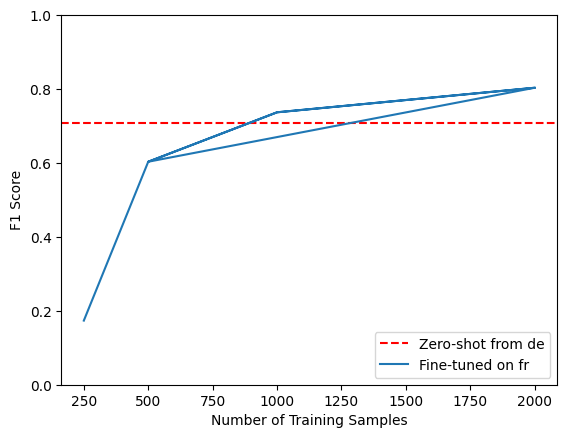

In [81]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

In [82]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    """
    Function to concatenate multiple corpora together, and shuffle the result.

    Parameters:
    corpora (list): A list of corpora, where each corpus is an instance of DatasetDict from the HuggingFace `datasets` library.
                     Each DatasetDict should contain the same train/validation/test splits.

    Returns:
    multi_corpus (DatasetDict): A DatasetDict containing the concatenated and shuffled datasets.
    """

    # Initialize an empty DatasetDict to hold the concatenated datasets.
    multi_corpus = DatasetDict()

    # For each split (train, validation, test) in the first corpus in the list...
    for train_val_test_split in corpora[0].keys():

        # Concatenate the corresponding split from all corpora in the list.
        # The `concatenate_datasets` function from HuggingFace `datasets` is used here.
        # The concatenated dataset is then shuffled with a fixed seed for reproducibility.
        multi_corpus[train_val_test_split] = concatenate_datasets(
            [corpus[train_val_test_split] for corpus in corpora]).shuffle(seed=42)

    # Return the concatenated and shuffled DatasetDict.
    return multi_corpus


In [83]:
panx_de_fr_concatenated_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [89]:
import gc
gc.collect()
os.environ["CUDA_VISIBLE_DEVICES"]="1"
torch.cuda.set_device(1)
torch.cuda.empty_cache()

training_args.logging_steps = len(panx_de_fr_concatenated_encoded["train"]) // batch_size
# training_args.push_to_hub = True
training_args.push_to_hub = False  # PAUL - Changing to False
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_concatenated_encoded["train"],
    eval_dataset=panx_de_fr_concatenated_encoded["validation"])

trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.189590,0.812249
2,No log,0.164295,0.848188
3,No log,0.163690,0.855953


eval_pred.predictions  [[[   3.0771189    -0.598589     -0.7140426  ...   -0.7052609
      0.5747626    -1.3551121 ]
  [   7.884901     -1.8699633    -1.517168   ...   -1.107081
     -1.0663092    -1.7805163 ]
  [   7.9407663    -2.0293598    -1.4216915  ...   -0.8906573
     -1.2543356    -1.5873696 ]
  ...
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]]

 [[   3.6607487    -1.6986357    -1.8648319  ...   -1.4140469
      1.4351432     0.5210339 ]
  [   6.302573     -1.5369805    -2.2299025  ...   -1.7758459
      0.8665931    -1.9704179 ]
  [   7.233485     -2.166623     -2.2204573  ...   -1.0241097
     -0.53265417   -1.4169366 ]
  ...
  [-100.         -100.         -100.         ... -100.
   -100.         -100.        ]
  [-100.         -100.         -100.         ... -10

TrainOutput(global_step=1611, training_loss=0.17946025675531502, metrics={'train_runtime': 645.7978, 'train_samples_per_second': 79.715, 'train_steps_per_second': 2.495, 'total_flos': 1217861247419520.0, 'train_loss': 0.17946025675531502, 'epoch': 3.0})

In [91]:
for lang in languages:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

/home/raj/.conda/envs/raj/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


eval_pred.predictions  [[[ 1.0373670e+00 -2.5196846e+00 -1.2868844e+00 ... -4.7649765e-01
    9.8365921e-01  4.6399751e+00]
  [ 8.8123932e+00 -1.8669630e+00 -2.3624783e+00 ... -1.3708290e+00
   -1.2128159e+00 -1.8676190e+00]
  [ 8.6757622e+00 -1.8588327e+00 -2.2637541e+00 ... -1.1624765e+00
   -1.2762370e+00 -1.4709924e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 4.4714441e+00  2.6543674e-01 -1.0954884e+00 ... -8.6127478e-01
   -1.5749955e-01 -2.6510355e+00]
  [ 9.0881948e+00 -1.5009668e+00 -1.9254508e+00 ... -1.3495163e+00
   -1.6390302e+00 -2.0563157e+00]
  [-2.4809415e+00  7.0502477e+00 -1.0807505e+00 ... -8.2349193e-01
   -2.4597093e-01 -3.5949492e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-e0f733454a77c6e3.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-428c0ad2f890b9e4.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-4595e33651fa990a.arrow


F1-score of [de-fr] model on [de] dataset: 0.864


eval_pred.predictions  [[[ 1.2788754e+00  1.0256761e-01 -7.1424395e-01 ... -3.1762287e-01
   -4.9012980e-01 -4.5980361e-01]
  [ 8.0796852e+00 -1.5753639e+00 -1.5942718e+00 ... -1.0868329e+00
   -1.4891094e+00 -2.2354872e+00]
  [ 8.2575998e+00 -1.5682460e+00 -1.6538008e+00 ... -8.9613837e-01
   -1.6109847e+00 -2.2690578e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 1.6414437e+00 -5.4920310e-01 -1.4428914e+00 ... -6.9410306e-01
    2.9149535e-01  7.4250735e-02]
  [ 7.6763973e+00 -1.5559667e+00 -2.3128316e+00 ... -1.9272563e+00
   -6.5767646e-01 -2.4658213e+00]
  [ 7.6598663e+00 -1.9512451e+00 -2.2052319e+00 ... -1.7926939e+00
   -7.4470687e-01 -2.1214256e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-0aca5f2553f92f34.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-6600f7a976c53871.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-838480ede753f20c.arrow


F1-score of [de-fr] model on [fr] dataset: 0.853


eval_pred.predictions  [[[ 3.7166357e+00 -1.2619112e+00 -2.2557929e+00 ...  5.6298733e-01
    1.1598121e-01 -5.2288496e-01]
  [ 8.6381283e+00 -1.8671875e+00 -2.1196425e+00 ... -1.4462342e+00
   -9.8055744e-01 -2.2343080e+00]
  [ 8.3918514e+00 -2.1022918e+00 -2.3110900e+00 ... -1.1444126e+00
   -7.0494413e-01 -1.8374062e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1.0000000e+02
   -1.0000000e+02 -1.0000000e+02]]

 [[ 4.4032230e+00 -1.8947252e+00 -2.6837313e+00 ... -1.4222655e+00
    1.0620900e+00  1.1252093e+00]
  [ 8.3659286e+00 -1.7641534e+00 -2.1449032e+00 ... -1.3957684e+00
   -9.5517170e-01 -1.9215144e+00]
  [ 8.7616568e+00 -2.1901000e+00 -1.9285494e+00 ... -8.8651001e-01
   -1.7049687e+00 -1.3584644e+00]
  ...
  [-1.0000000e+02 -1.0000000e+02 -1.0000000e+02 ... -1

Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-85e11aea0c209c3a.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-4d29ec81a064ef61.arrow
Loading cached processed dataset at /home/raj/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4/cache-4c06b3c347f3c313.arrow


F1-score of [de-fr] model on [it] dataset: 0.801


eval_pred.predictions  [[[ 5.42772484e+00 -1.14976752e+00 -2.47005749e+00 ... -8.94829690e-01
    3.69182825e-01 -2.07568240e+00]
  [ 8.96281528e+00 -1.86973000e+00 -1.72235703e+00 ... -1.12721860e+00
   -1.59222066e+00 -2.01083302e+00]
  [ 8.92686749e+00 -2.17295671e+00 -1.84569728e+00 ... -9.90983546e-01
   -1.57947874e+00 -1.61154556e+00]
  ...
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]
  [-1.00000000e+02 -1.00000000e+02 -1.00000000e+02 ... -1.00000000e+02
   -1.00000000e+02 -1.00000000e+02]]

 [[ 1.81065786e+00  1.89489579e+00  1.40676618e+00 ... -1.45626545e+00
   -3.41588467e-01 -2.74682546e+00]
  [-1.22674024e+00  8.10274792e+00 -7.53084064e-01 ... -1.53944945e+00
   -8.67390633e-01 -3.51252913e+00]
  [-1.86238158e+00 -4.87005949e-01  7.45576572e+00 ...  8.61150742e-01
   -2.64542413e+00 -1.39375198e+00]
  ...


In [ ]:
torch.cuda.empty_cache()

corpora = [panx_de_encoded]

# Exclude German from iteration
for lang in languages[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ds_combined[lang])
    metrics = fine_tuning_training_on_single_corpus(ds_encoded, ds_encoded["train"].num_rows)
    # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

**Multilingual Training**

In [ ]:
corpora_encoded = concatenate_splits(corpora)

In [ ]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()

In [ ]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in languages},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

In [ ]:
# Evaluated on -->	de	fr	it	en
# Fine-tune on   
# de	        0.8691	0.7016	0.6739	0.5921
# each	        0.8691	0.8372	0.8178	0.7084
# all	        0.8697	0.8729	0.8698	0.7724